## Todo
* We need to process SmartDoc dataset into a format that can be used by the models. That is to have to images, one the RGB and one the mask.
* Then this can be used for training the model.

In [1]:
import pathlib
import logging
import sys
sys.path.append("../")

In [2]:
import dataprocessor
import utils
from experiment import Experiment

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from torchvision.utils import make_grid
from torchvision.io import read_image
import torchvision.transforms.functional as F
import pandas as pd

In [5]:
import torch

In [6]:
from torch.utils.data import Dataset
from torchvision import transforms

In [7]:
from dataprocessor import SmartDocDataset

In [8]:
name = "new-era"
out_dir = pathlib.Path("../experiments/")

In [9]:
cuda = False

In [10]:
dataset_path_train = pathlib.Path("../../data-doc/SmartDocMaskedTrain")
dataset_path_valid = pathlib.Path("../../data-doc/SmartDocMaskedValid")
dataset_train = SmartDocDataset(directory=dataset_path_train)
dataset_valid = SmartDocDataset(directory=dataset_path_valid)

In [11]:
cuda = torch.cuda.is_available() and cuda
kwargs = {"num_workers": 2, "pin_memory": False} if cuda else {}

In [12]:
from torch.utils.data import DataLoader
batch_size = 4
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, **kwargs)
valid_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True, **kwargs)

# The Model

In [13]:
import torch
import torch.nn.functional as F

In [14]:
import segmentation_models_pytorch as smp

In [15]:
myModel = smp.Unet(
    encoder_name="mobilenet_v2",    # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    # encoder_depth=4,
    # decoder_channels=(256, 128, 64, 32),
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

In [16]:
if cuda:
    myModel.cuda()

In [17]:
model_path = "../../experiments/t10/2022-02-23/00-47-46_0/resnet20.pb"

In [18]:
# model_path = "../../experiments/t11/2022-02-23/15-33-36_0/resnet20.pb"

In [19]:
myModel.load_state_dict(torch.load(model_path))
myModel.eval();

In [20]:
images_iter = iter(valid_dataloader)

In [193]:
images = images_iter.next()[0]

In [194]:
images.shape

torch.Size([4, 3, 512, 512])

In [195]:
import torchvision.transforms.functional as F
def show(imgs, ncols=4):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=ncols, squeeze=False, figsize=(ncols * 4, len(imgs) * 4))
    for i, img in enumerate(imgs[:ncols]):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [196]:
if cuda:
    outputs = myModel(images.cuda())
else: 
    outputs = myModel(images)

In [197]:
from torchvision.utils import draw_segmentation_masks

docs_w_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=0.7)
    for img, mask in zip((images * 255).to(torch.uint8), outputs < 0.5)
]

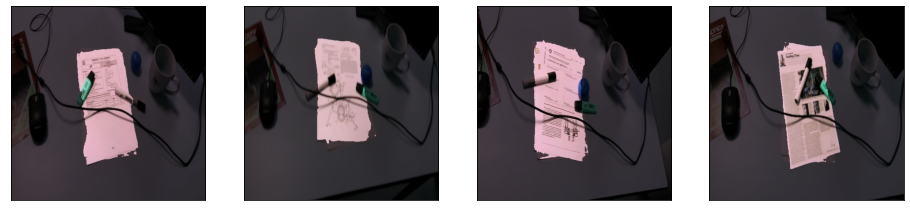

In [198]:
show(docs_w_masks)

# tidy up the blob

In [199]:
import cv2

In [219]:
image_idx = 2

In [220]:
# first let's grab one image and mask
img = images[image_idx].numpy() * 255
mask = outputs[image_idx].detach().numpy().squeeze() * 255

In [221]:
img.shape, mask.shape

((3, 512, 512), (512, 512))

In [222]:
ret, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY) 

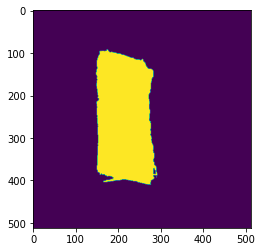

In [223]:
plt.imshow(thresh)

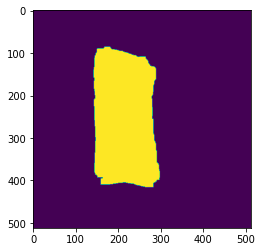

In [224]:
# Dilate the mask
kernel = np.ones((5,5),np.uint8)
dilated = cv2.dilate(thresh, kernel, iterations=3)
plt.imshow(dilated)

In [225]:
# find contours
contours, hierarchy = cv2.findContours(dilated.astype(np.uint8), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


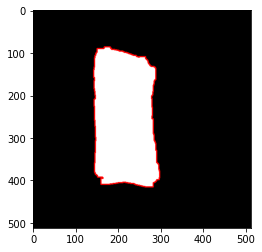

In [226]:
im = np.expand_dims(dilated, axis=2).repeat(3, axis=2) 
for k, _ in enumerate(contours):
    im = cv2.drawContours(im, contours, k, (255, 0, 0), 2)
plt.imshow(im)

In [227]:
# select the largest contour
contour = max(contours, key = cv2.contourArea)
# simplify the contour
epsilon = 0.1*cv2.arcLength(contour, True)
approx = cv2.approxPolyDP(contour, epsilon, True)

In [228]:
img_cv2_style = img.transpose(1, 2, 0).copy()  / 255

In [229]:
im = cv2.drawContours(img_cv2_style, [approx], 0, (255, 0, 0), 2)

In [230]:
cv2.UMat(img_cv2_style)

<UMat 0x7f7554a1cd10>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


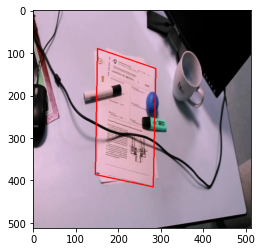

In [231]:
plt.imshow(img_cv2_style)